In [2]:
import numpy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
torch_seed = 42 
torch.manual_seed(torch_seed)
torch.cuda.manual_seed_all(torch_seed)
torch.cuda.manual_seed(torch_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model

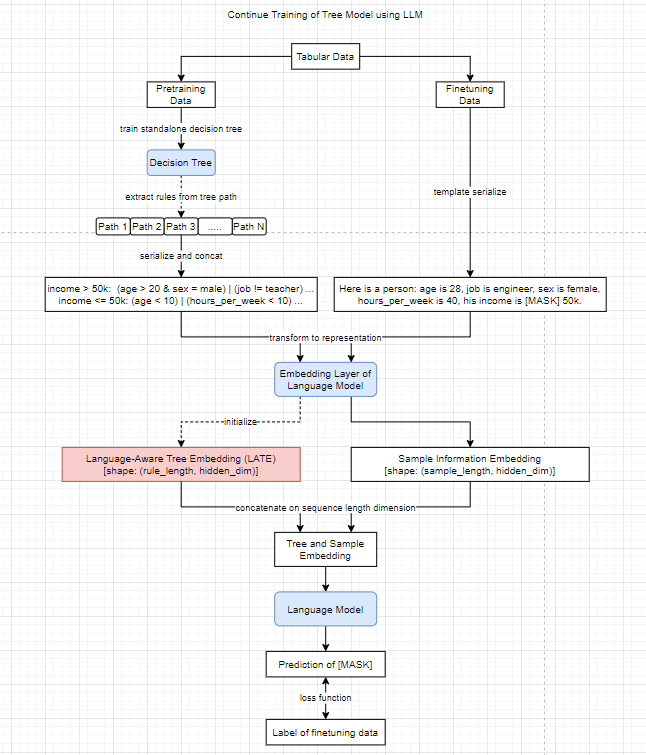

## Load Dataset

In [4]:
Iris_Dataset = datasets.load_iris()
X = Iris_Dataset.data
y = Iris_Dataset.target

df = pd.DataFrame(
    Iris_Dataset.data, 
    columns=Iris_Dataset.feature_names
    )
 
df['target'] = Iris_Dataset.target
 
# Map targets to target names
target_names = {
    0:'setosa',
    1:'versicolor', 
    2:'virginica'
}
 
df['target_names'] = df['target'].map(target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [5]:
df['target'].value_counts()
# It's balanced

target
0    50
1    50
2    50
Name: count, dtype: int64

In [6]:
# split dataset into pretrained_data and finetune_data
X_pre, X_fine, y_pre, y_fine = train_test_split(X, y, test_size=0.2, random_state=torch_seed, stratify=y)

## Decision Tree

In [32]:
Tree_model = DecisionTreeClassifier(max_depth=3, random_state=torch_seed)
Tree_model.fit(X_pre, y_pre)

# Show rules
rule_text = tree.export_text(Tree_model, feature_names=Iris_Dataset.feature_names)
print(rule_text)

# Show sample path
print(X_pre[1].reshape(1, -1))
node_indicator = Tree_model.decision_path(X_pre[1].reshape(1, -1))
leaf_id = Tree_model.apply(X_pre[1].reshape(1, -1))
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]
print(node_index)
print(leaf_id)
feature = Tree_model.tree_.feature
threshold = Tree_model.tree_.threshold
sample_id = 1
for node_id in node_index:
    if leaf_id[0] == node_id:
        continue
    if X_pre[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"
    print(
            "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=X_pre[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.65
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.65
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2

[[4.9 2.5 4.5 1.7]]
[0 2 6 7]
[7]
decision node 0 : (X_test[1, 2] = 4.5) > 2.449999988079071)
decision node 2 : (X_test[1, 3] = 1.7) > 1.6500000357627869)
decision node 6 : (X_test[1, 2] = 4.5) <= 4.8500001430511475)


In [43]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# 加载数据集
iris = load_iris()
X, y = iris.data, iris.target

# 训练决策树模型
clf = DecisionTreeClassifier(max_depth=3, random_state=torch_seed)
clf.fit(X, y)

# 定义一个递归函数来获取所有路径
def get_tree_paths(tree, feature_names):
    paths = []
    
    def recurse(node, path):
        if tree.feature[node] != -2:  # -2 表示叶节点
            name = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]
            left_decision = f"{name} <= {threshold:.2f}"
            right_decision = f"{name} > {threshold:.2f}"
            recurse(tree.children_left[node], path + [left_decision])
            recurse(tree.children_right[node], path + [right_decision])
        else:
            paths.append((path, node))
    
    recurse(0, [])
    return paths

# 获取所有路径
paths = get_tree_paths(clf.tree_, iris.feature_names)

# 打印所有路径
for path, node in paths:
    print("Path:")
    for p in path:
        print("  " + p)
    print(f"node {node}")
    print()

Path:
  petal length (cm) <= 2.45
node 1

Path:
  petal length (cm) > 2.45
  petal width (cm) <= 1.75
  petal length (cm) <= 4.95
node 4

Path:
  petal length (cm) > 2.45
  petal width (cm) <= 1.75
  petal length (cm) > 4.95
node 5

Path:
  petal length (cm) > 2.45
  petal width (cm) > 1.75
  petal length (cm) <= 4.85
node 7

Path:
  petal length (cm) > 2.45
  petal width (cm) > 1.75
  petal length (cm) > 4.85
node 8



In [7]:
Decision_train_acc = Tree_model.score(X_pre, y_pre)
print(Decision_train_acc)
Decision_tree_acc = Tree_model.score(X_fine, y_fine)
print(Decision_tree_acc)

0.9833333333333333
0.9666666666666667


In [8]:
def rule_of_sample(X, feature_names):
    sample = 'Here is an iris: '
    for i in range(len(X)):
        sample += f'{feature_names[i]} is {X[i]}, '
    sample += 'it belongs to class [MASK]'
    return sample
    
print(rule_of_sample(X_pre[0], Iris_Dataset.feature_names))

Here is an iris: sepal length (cm) is 4.4, sepal width (cm) is 2.9, petal length (cm) is 1.4, petal width (cm) is 0.2, it belongs to class [MASK]


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bertmodel = BertModel.from_pretrained('bert-base-uncased')
for param in bertmodel.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
rule_text_token = tokenizer(rule_text, return_tensors="pt")
rule_text_emb = bertmodel.embeddings(input_ids=rule_text_token['input_ids'], token_type_ids=rule_text_token['token_type_ids'])

## Train Linear Layers

In [11]:
class iris_dataset(Dataset):
    def __init__(self, mode='pretrain'):
        if mode == 'pretrain':
            self.data = X_pre
            self.target = y_pre
        elif mode == 'finetune':
            self.data = X_fine
            self.target = y_fine
            
    def __getitem__(self, index):
        # Returns one sample at a time
        return self.data[index], self.target[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)
    
def prep_dataloader(mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = iris_dataset(mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [12]:
class LLMTree(nn.Module):
    def __init__(self, LLM_model, LLM_tokenizer, batch_size, device):
        super(LLMTree, self).__init__()
        self.LLM_model = LLM_model
        self.LLM_emb_layer = LLM_model.embeddings
        self.tokenizer = LLM_tokenizer
        self.LLM_hidden_dim = 768
        self.class_num = 3
        self.batch_size = batch_size
        self.feature_names = Iris_Dataset.feature_names
        self.rule_emb = rule_text_emb
        
        self.linear = nn.Sequential(
            nn.Linear(self.LLM_hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, self.class_num)
        )
        
    def rule_of_sample(self, X):
        batch_sample = []
        for n in range(len(X)):
            sample = 'Here is an iris: '
            for i in range(len(X[n])):
                sample += f'{self.feature_names[i]} is {X[n][i]}, '
            sample += 'it belongs to class [MASK]'
            batch_sample.append(sample)
        return batch_sample
    
    def cal_loss(self, pred, target):
        self.criterion = nn.CrossEntropyLoss()

        return self.criterion(pred, target)
        
    def forward(self, x, device):
        x = self.tokenizer(self.rule_of_sample(x), return_tensors="pt")
        x = self.LLM_emb_layer(input_ids=x['input_ids'].to(device), token_type_ids=x['token_type_ids'].to(device))
        x = torch.cat((self.rule_emb.repeat(x.shape[0], 1, 1).to(device), x), 1)  # batch*(rule+x)*768
        x = self.LLM_model(inputs_embeds=x)['pooler_output'] 
        x = self.linear(x)
        return x

In [13]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# get device 
device = torch.device("cuda:1")

# training parameters
batch_size = 4
max_epoch = 100               # number of training epoch
learning_rate = 0.0001        # learning rate
early_stopping_step = 10

# the path where checkpoint saved
model_path = 'models/pretrainLLM.pth'
bestmodel_path = 'models/BestModel/Best_pretrainLLM.pth'

In [15]:
def train_linear(tr_set, dv_set, model, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch = 0
    min_loss = 100000.
    record = {'train': {'loss':[], 'acc':[]}, 'dev': {'loss':[], 'acc':[]}}
    early_stopping_count = 0
    while (epoch < max_epoch) and (early_stopping_count<early_stopping_step):
        acc = 0
        print('\n-----epoch= {:3d}'.format(epoch + 1), end='. ')
        model.train()
        loss = 0
        train_loss = 0
        for x, label in tqdm(tr_set):
            optimizer.zero_grad()
            x, label = x.to(device), label.to(device)
            pred = model(x, device)
            loss = model.cal_loss(pred, label)
            train_loss += loss
            for p in range(len(pred)):
                if torch.argmax(pred[p]) == label[p]:
                    acc += 1
            loss.backward()                
            optimizer.step()                    
        record['train']['loss'].append((train_loss / len(tr_set.dataset)).detach().cpu().item())
        record['train']['acc'].append(acc / len(tr_set.dataset))
        dev_loss, dev_acc = dev(dv_set, model, device)
        record['dev']['loss'].append(dev_loss)
        record['dev']['acc'].append(dev_acc)
        if dev_loss < min_loss:
            early_stopping_count = 0
            min_loss = dev_loss
            print('\n-----epoch= {:3d}, dev_loss= [{:.6f}]'.format(epoch + 1, dev_loss), end=', ')
            print('\n\t train loss=[{:.6f}]'.format(record['train']['loss'][-1]), end=', ')
            torch.save(model.state_dict(), model_path)
        else:
            early_stopping_count += 1
        epoch += 1
    if early_stopping_count>=early_stopping_step:
        print('Early stopping !!!')
    else:
        print('Finished training !!!')
    return epoch + 1, record

In [16]:
def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    acc = 0
    for x, label in tqdm(dv_set):                         
        x, label = x.to(device), label.to(device)       
        with torch.no_grad():                   
            pred = model(x, device)
            loss = model.cal_loss(pred, label)
            for p in range(len(pred)):
                if torch.argmax(pred[p]) == label[p]:
                    acc += 1
        total_loss += loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(dv_set.dataset)
    dev_acc = acc / len(dv_set.dataset)
    return total_loss, dev_acc

In [17]:
tr_set = prep_dataloader('pretrain', batch_size)
dv_set = prep_dataloader('finetune', batch_size)

model = LLMTree(bertmodel, tokenizer, batch_size, device).to(device)

In [18]:
model_epoch, model_record = train_linear(tr_set, dv_set, model, device)


-----epoch=   1. 

100%|██████████| 8/8 [00:00<00:00, 28.00it/s]



-----epoch=   1, dev_loss= [1.098872], 
	 train loss=[0.277336], 
-----epoch=   2. 

100%|██████████| 8/8 [00:00<00:00, 28.15it/s]



-----epoch=   2, dev_loss= [1.098736], 
	 train loss=[0.275992], 
-----epoch=   3. 

100%|██████████| 8/8 [00:00<00:00, 29.01it/s]



-----epoch=   4. 

100%|██████████| 8/8 [00:00<00:00, 25.71it/s]



-----epoch=   5. 

100%|██████████| 8/8 [00:00<00:00, 28.16it/s]



-----epoch=   6. 

100%|██████████| 8/8 [00:00<00:00, 27.67it/s]



-----epoch=   6, dev_loss= [1.098718], 
	 train loss=[0.275551], 
-----epoch=   7. 

100%|██████████| 8/8 [00:00<00:00, 28.01it/s]



-----epoch=   8. 

100%|██████████| 8/8 [00:00<00:00, 26.68it/s]



-----epoch=   9. 

100%|██████████| 8/8 [00:00<00:00, 27.93it/s]



-----epoch=  10. 

100%|██████████| 8/8 [00:00<00:00, 28.18it/s]



-----epoch=  11. 

100%|██████████| 8/8 [00:00<00:00, 26.63it/s]



-----epoch=  12. 

100%|██████████| 8/8 [00:00<00:00, 27.29it/s]



-----epoch=  13. 

100%|██████████| 8/8 [00:00<00:00, 25.74it/s]



-----epoch=  14. 

100%|██████████| 8/8 [00:00<00:00, 24.66it/s]



-----epoch=  14, dev_loss= [1.098712], 
	 train loss=[0.275316], 
-----epoch=  15. 

100%|██████████| 8/8 [00:00<00:00, 27.17it/s]



-----epoch=  16. 

100%|██████████| 8/8 [00:00<00:00, 28.96it/s]



-----epoch=  16, dev_loss= [1.098694], 
	 train loss=[0.275349], 
-----epoch=  17. 

100%|██████████| 8/8 [00:00<00:00, 27.69it/s]



-----epoch=  18. 

100%|██████████| 8/8 [00:00<00:00, 28.17it/s]



-----epoch=  19. 

100%|██████████| 8/8 [00:00<00:00, 24.70it/s]



-----epoch=  19, dev_loss= [1.098619], 
	 train loss=[0.275389], 
-----epoch=  20. 

100%|██████████| 8/8 [00:00<00:00, 28.50it/s]



-----epoch=  20, dev_loss= [1.098608], 
	 train loss=[0.275380], 
-----epoch=  21. 

100%|██████████| 8/8 [00:00<00:00, 27.06it/s]



-----epoch=  21, dev_loss= [1.098607], 
	 train loss=[0.275245], 
-----epoch=  22. 

100%|██████████| 8/8 [00:00<00:00, 26.09it/s]



-----epoch=  23. 

100%|██████████| 8/8 [00:00<00:00, 23.92it/s]



-----epoch=  24. 

100%|██████████| 8/8 [00:00<00:00, 26.36it/s]



-----epoch=  25. 

100%|██████████| 8/8 [00:00<00:00, 27.61it/s]



-----epoch=  26. 

100%|██████████| 8/8 [00:00<00:00, 27.08it/s]



-----epoch=  27. 

100%|██████████| 8/8 [00:00<00:00, 27.17it/s]



-----epoch=  27, dev_loss= [1.098596], 
	 train loss=[0.275217], 
-----epoch=  28. 

100%|██████████| 8/8 [00:00<00:00, 27.87it/s]



-----epoch=  28, dev_loss= [1.098595], 
	 train loss=[0.275030], 
-----epoch=  29. 

100%|██████████| 8/8 [00:00<00:00, 26.79it/s]



-----epoch=  30. 

100%|██████████| 8/8 [00:00<00:00, 28.07it/s]



-----epoch=  31. 

100%|██████████| 8/8 [00:00<00:00, 28.04it/s]



-----epoch=  32. 

100%|██████████| 8/8 [00:00<00:00, 27.53it/s]



-----epoch=  33. 

100%|██████████| 8/8 [00:00<00:00, 26.25it/s]



-----epoch=  34. 

100%|██████████| 8/8 [00:00<00:00, 25.24it/s]



-----epoch=  35. 

100%|██████████| 8/8 [00:00<00:00, 25.89it/s]



-----epoch=  36. 

100%|██████████| 8/8 [00:00<00:00, 26.43it/s]



-----epoch=  36, dev_loss= [1.098594], 
	 train loss=[0.274864], 
-----epoch=  37. 

100%|██████████| 8/8 [00:00<00:00, 26.68it/s]



-----epoch=  38. 

100%|██████████| 8/8 [00:00<00:00, 25.31it/s]



-----epoch=  39. 

100%|██████████| 8/8 [00:00<00:00, 26.61it/s]



-----epoch=  40. 

100%|██████████| 8/8 [00:00<00:00, 24.86it/s]



-----epoch=  41. 

100%|██████████| 8/8 [00:00<00:00, 25.24it/s]



-----epoch=  42. 

100%|██████████| 8/8 [00:00<00:00, 26.35it/s]



-----epoch=  43. 

100%|██████████| 8/8 [00:00<00:00, 24.09it/s]



-----epoch=  44. 

100%|██████████| 8/8 [00:00<00:00, 24.16it/s]



-----epoch=  45. 

100%|██████████| 8/8 [00:00<00:00, 24.10it/s]



-----epoch=  46. 

100%|██████████| 8/8 [00:00<00:00, 24.58it/s]

Early stopping !!!


In [20]:
# del model
model = LLMTree(bertmodel, tokenizer, batch_size, device).to(device)
ckpt = torch.load(bestmodel_path, map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

## loss & acc

No handles with labels found to put in legend.


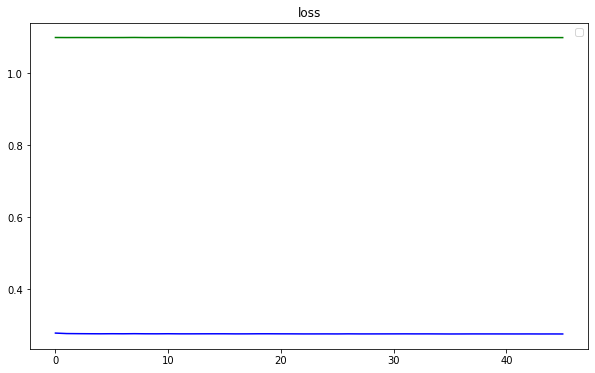

No handles with labels found to put in legend.


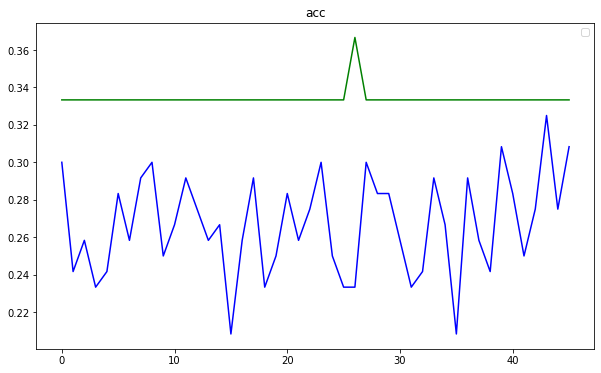

In [22]:
%matplotlib inline

plt.figure(figsize=(10,6))
plt.title('loss')
plt.plot(range(model_epoch - 1), model_record['train']['loss'], color='blue')
plt.plot(range(model_epoch - 1), model_record['dev']['loss'], color='green')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.title('acc')
plt.plot(range(model_epoch - 1), model_record['train']['acc'], color='blue')
plt.plot(range(model_epoch - 1), model_record['dev']['acc'], color='green')
plt.legend()
plt.show()